In [41]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import json
from ROOT import TLorentzVector
from optparse import OptionParser, make_option
from  pprint import pprint
import commands
import time
import datetime
start_time = time.time()

In [42]:
filedir = '/work/nchernya/HHbbgg_ETH_devel/outfiles/20190321_2017_2016_for_optimization/'
filename = 'Total_preselection_diffNaming_2016_2017_21_03_2019_transformedMVA.root'

sig_names = ['reducedTree_sig','reducedTree_sig_2017']
bkg_names = ['reducedTree_bkg_0','reducedTree_bkg_1','reducedTree_bkg_2','reducedTree_bkg_0_2017']
signal_list = []
bkg_list = []
lumi_ratio = 41.5/35.9

for sig in sig_names:
    df = rpd.read_root(filedir+filename,sig, columns = ['MX',"Mjj","event","weight",'overlapSave','MVAOutputTransformed'])
    if '2017' in sig:
        df['weight']*=lumi_ratio
    signal_list.append(df)
for bkg in bkg_names:
    df = rpd.read_root(filedir+filename,bkg, columns = ['MX',"Mjj","event","weight",'overlapSave','MVAOutputTransformed'])
    if '2017' in bkg:
        df['weight']*=lumi_ratio 
    df['weight'] = df['weight']*df['overlapSave']
    bkg_list.append(df)    

sig = pd.concat(signal_list, axis=0, ignore_index=True)
bkg = pd.concat(bkg_list, axis=0, ignore_index=True)

In [43]:
outstr = "24_05_2019_classification"
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [44]:
def get_total_test_sample_event_num(x_sig,x_bkg,event_sig,event_bkg,sig_frac=2,bkg_frac=5):
    x_s = x_sig[np.where(event_sig%sig_frac==0)]
    x_b = x_bkg[np.where(event_bkg%bkg_frac==0)]
    return np.concatenate((x_s,x_b))

def get_total_training_sample_event_num(x_sig,x_bkg,event_sig,event_bkg,sig_frac=2,bkg_frac=5):
    x_s = x_sig[np.where(event_sig%sig_frac!=0)]
    x_b = x_bkg[np.where(event_bkg%bkg_frac!=0)]
    return np.concatenate((x_s,x_b))

In [45]:
branch_names = 'MX,MVAOutputTransformed'.split(",") 
event_branches = ['event','weight','overlapSave']
branch_names = [c.strip() for c in branch_names]

X_sig =  np.asarray(sig[branch_names])
w_sig =  np.asarray(sig['weight'])
w_sig = w_sig/w_sig.sum()
event_sig =  np.asarray(sig['event'])
y_sig =  np.asarray((np.ones_like(sig.index)*1).astype(np.int8))

X_bkg =  np.asarray(bkg[branch_names])
w_bkg =  np.asarray(bkg['weight'])
w_bkg = w_bkg/w_bkg.sum()
event_bkg =  np.asarray(bkg['event'])
y_bkg =  np.asarray((np.ones_like(bkg.index)*-1).astype(np.int8))

#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig,y_bkg,event_sig,event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig,event_bkg)

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig,y_bkg,event_sig,event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig,event_bkg)

w_total_train = preprocessing.get_total_training_sample_event_num(w_sig,w_bkg,event_sig,event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(w_sig,w_bkg,event_sig,event_bkg).ravel()


In [47]:
print "Starting the training now : "
now = str(datetime.datetime.now())
print(now)

################Training a classifier###############
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
n_threads=20

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
   max_depth=3, min_child_weight=0.0001, 
   n_estimators=1000, n_jobs=1, nthread=n_threads, objective='binary:logistic',
   random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
   seed=0, silent=True, subsample=1)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)


print 'Training is done. It took', time.time()-start_time, 'seconds.'

joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)


Starting the training now : 
2019-05-24 16:19:09.128862
Training is done. It took 292.210858107 seconds.


['/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_24_05_2019_classification.pkl']

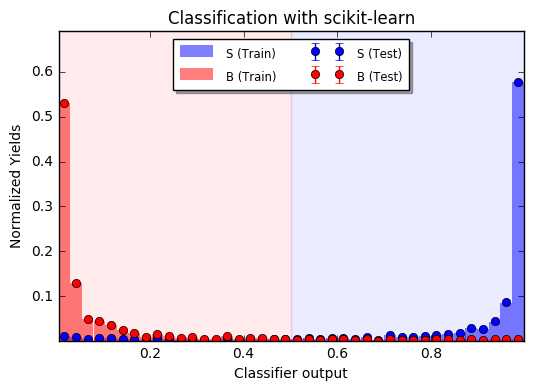

In [49]:
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

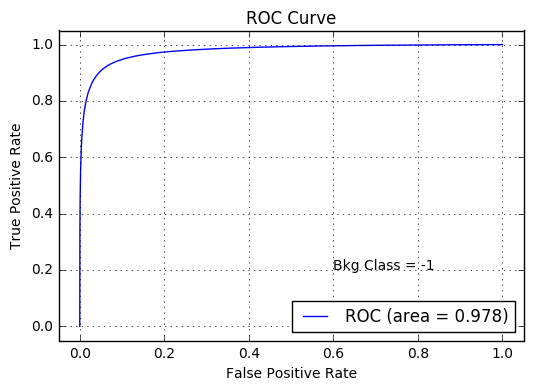

In [54]:
fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()

## Categorization by MX times MVA

In [102]:
categories_MX = [250,336, 411 ,556]
categories_MVA = [ 0.230 , 0.455, 0.709]



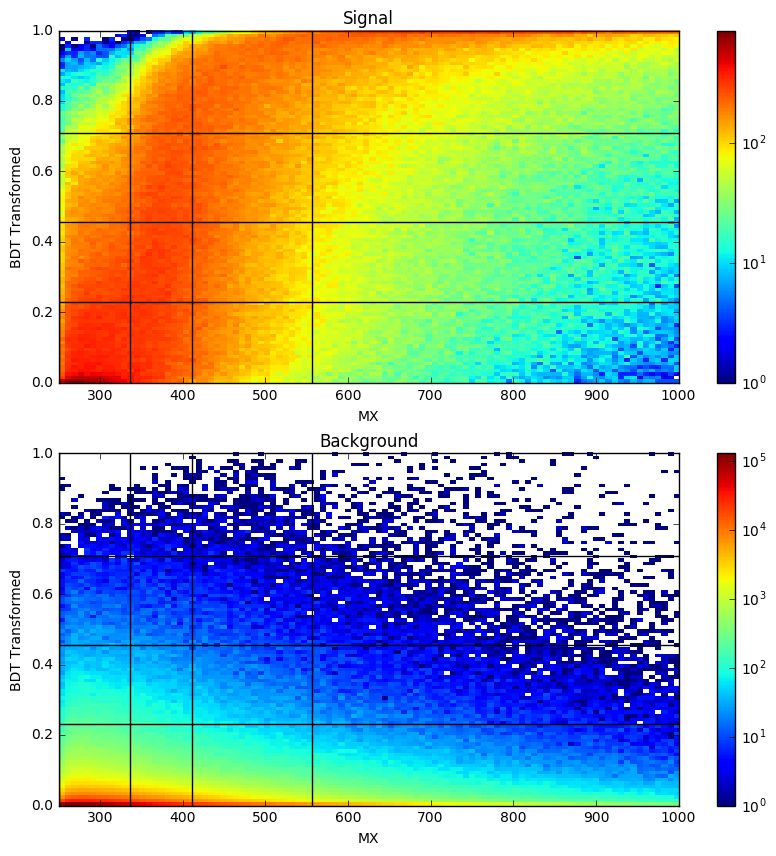

In [105]:
plt.clf()
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))

plt.subplot(2,1, 1)
plt.title('Signal')
plt.xlabel('MX')
plt.ylabel('BDT Transformed')
img_sig = plt.hist2d(sig['MX'],sig['MVAOutputTransformed'], bins=(100,100),range=[[250,1000],[0,1]],norm=LogNorm())
plt.colorbar()
for mx in categories_MX:
    x = np.linspace(mx,mx)
    plt.plot(x, np.linspace(0,1), color="k")
for mva in categories_MVA:
    x = np.linspace(mva,mva)
    plt.plot(np.linspace(250,1000),x, color="k")    


plt.subplot(2,1, 2)
plt.title('Background')
img_bkg = plt.hist2d(bkg['MX'],bkg['MVAOutputTransformed'], bins=(100,100),range=[[250,1000],[0,1]],norm=LogNorm())
plt.xlabel('MX')
plt.ylabel('BDT Transformed')
plt.colorbar()
for mx in categories_MX:
    x = np.linspace(mx,mx)
    plt.plot(x, np.linspace(0,1), color="k")
for mva in categories_MVA:
    x = np.linspace(mva,mva)
    plt.plot(np.linspace(250,1000),x, color="k") 

plt.subplots_adjust(wspace=0.5, hspace=.2)
plt.show()